# Regressão para 60 minutos <br>
por [Marina Galdez de Castro Silva](mailto:marinagaldez@id.uff.br) <br>
2023
<br>

## Preparo

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
from datetime import datetime, timedelta

## Carregar e visualizar dados - se atente em importar seus dados no formato e nomes das coluna sugeridos

In [ ]:
# Carregar os dados do Excel no Google Colab

ponto1 = pd.read_excel('Ponto1_j.xlsx')
ponto2 = pd.read_excel('Ponto2.xlsx')
ponto4 = pd.read_excel('Ponto4.xlsx')

# Dados organizados em excel com colunas: ANO	MÊS	DIA	HORA	DATA_HORA	PRECIPITACAO
# Exemplo: 2018	12	18	11:39:04	18/12/18 11:39	2,2

In [ ]:
ponto1

,ANO,MÊS,DIA,HORA,DATA_HORA,DATA_NUMBER,PRECIPITACAO
0,2018,2,4,09:14:51,2018-02-04 09:14:51,43135.385313,0.0
1,2018,2,4,09:24:51,2018-02-04 09:24:51,43135.392257,0.0
2,2018,2,4,09:34:51,2018-02-04 09:34:51,43135.399201,0.0
3,2018,2,4,09:44:51,2018-02-04 09:44:51,43135.406146,0.0
4,2018,2,4,09:54:51,2018-02-04 09:54:51,43135.413090,0.0
...,...,...,...,...,...,...,...
140555,2020,11,25,10:05:06,2020-11-25 10:05:06,44160.420208,0.0
140556,2020,11,25,10:15:06,2020-11-25 10:15:06,44160.427153,0.0
140557,2020,11,25,10:25:06,2020-11-25 10:25:06,44160.434097,0.0
140558,2020,11,25,10:35:06,2020-11-25 10:35:06,44160.441042,0.0


## Processando os dados: Vamos fazer com que os dados de cada 10 minutos "passem" a ser horários

In [ ]:
def agregar_10_para_60min(df):
    df_agregado = pd.DataFrame()

    # Convertendo a coluna 'PRECIPITACAO' para float
    df['PRECIPITACAO'] = pd.to_numeric(df['PRECIPITACAO'].replace(',', '.', regex=True), errors='coerce')

    # Convertendo a coluna 'DATA_HORA' para datetime
    df['DATA_HORA'] = pd.to_datetime(df['DATA_HORA'], format='%d/%m/%y %H:%M:%S')

    # Agregando para resolução de 60 minutos
    df_agregado['DATA_HORA'] = pd.date_range(start=df['DATA_HORA'].iloc[0], end=df['DATA_HORA'].iloc[-1], freq='60T')
    df_agregado['PRECIPITACAO'] = df.groupby(pd.Grouper(key='DATA_HORA', freq='60T'))['PRECIPITACAO'].sum().reset_index(drop=True)

    return df_agregado

In [ ]:
# Função para agregar dados de 5 minutos para resolução de 60 minutos
def agregar_5_para_60min(df):
    df_agregado = pd.DataFrame()

    # Convertendo a coluna 'PRECIPITACAO' para float
    df['PRECIPITACAO'] = pd.to_numeric(df['PRECIPITACAO'].replace(',', '.', regex=True), errors='coerce')

    # Convertendo a coluna 'DATA_HORA' para datetime
    df['DATA_HORA'] = pd.to_datetime(df['DATA_HORA'], format='%d/%m/%y %H:%M:%S')

    # Agregando para resolução de 60 minutos
    df_agregado['DATA_HORA'] = pd.date_range(start=df['DATA_HORA'].iloc[0], end=df['DATA_HORA'].iloc[-1], freq='60T')
    df_agregado['PRECIPITACAO'] = df.groupby(pd.Grouper(key='DATA_HORA', freq='60T'))['PRECIPITACAO'].sum().reset_index(drop=True)

    return df_agregado

In [ ]:
# Agregação para 60 minutos para cada ponto
ponto1_agregado = agregar_10_para_60min(ponto1)
ponto2_agregado = agregar_5_para_60min(ponto2)
ponto4_agregado = agregar_5_para_60min(ponto4)

In [ ]:
ponto4_agregado.sort_values(by='PRECIPITACAO',ascending=False)


,DATA_HORA,PRECIPITACAO
3483,2019-05-13 12:40:00,16.6
663,2019-01-16 00:40:00,14.6
3482,2019-05-13 11:40:00,14.6
7563,2019-10-30 12:40:00,14.2
6575,2019-09-19 08:40:00,11.4
...,...,...
4158,2019-06-10 15:40:00,0.0
4159,2019-06-10 16:40:00,0.0
4160,2019-06-10 17:40:00,0.0
4161,2019-06-10 18:40:00,0.0


In [ ]:
ponto1_agregado.to_excel('ponto1_agregado.xlsx', index=False)
ponto2_agregado.to_excel('ponto2_agregado.xlsx', index=False)
ponto4_agregado.to_excel('ponto4_agregado.xlsx', index=False)

## Agora é para extrair as variáveis desejadas:


*   Agrupar em eventos isolados (quem faz parte da mesma chuva e quem pode ser considerado como outra)
*   Definir se é um evento erosivo
*   Calcular a intensidade
*   Calcular a energia cinética
*   Calcular a energia cinética total
*   Calcular/Procuar o (I30)60
*   Calcular o (EI30)60

Depois é calcular o EI30 mensal, a média mensal, o total e a média anual


In [ ]:
import pandas as pd
import numpy as np

# Função para atribuir um evento com base na precipitação
def atribuir_evento(df):
    # Criar uma nova coluna 'Evento'
    df['Evento'] = 0

    # Inicializar variáveis
    evento_atual = 0
    ultima_chuva = pd.to_datetime('1900-01-01 00:00:00')

    # Iterar sobre as linhas dos dados
    for index, row in df.iterrows():
        # Verificar se há precipitação
        if row['PRECIPITACAO'] > 0:
            # Verificar se é uma nova chuva
            if (row['DATA_HORA'] - ultima_chuva).total_seconds() / 3600 > 6:
                evento_atual += 1

            # Atualizar a coluna 'Evento'
            df.at[index, 'Evento'] = evento_atual

            # Atualizar a última chuva
            ultima_chuva = row['DATA_HORA']

    return df

# Função para processar dados horários
def processar_dados_horarios(df):
    # Adicionar coluna 'Evento' com base na precipitação
    df = atribuir_evento(df)

    # Criar uma nova coluna para identificar eventos erosivos
    df['Erosivos'] = 0

    # Inicializar o número do evento erosivo
    num_erosivo = 0

    # Iterar sobre os eventos para identificar os erosivos
    for evento in df['Evento'].unique():
        df_evento = df[df['Evento'] == evento]

        # Calcular a soma da precipitação total
        precipitacao_total = df_evento['PRECIPITACAO'].sum()

        # Verificar as condições
        if precipitacao_total >= 12.7:
            num_erosivo += 1
            # Atribuir o mesmo número erosivo a todo o grupo de eventos correspondente ao evento erosivo
            df.loc[df['Evento'] == evento, 'Erosivos'] = num_erosivo

    # Adicionar coluna 'I' (Intensidade) igual à precipitação apenas para eventos erosivos
    df['I'] = np.where(df['Erosivos'] != 0, df['PRECIPITACAO'], 0)

    # Adicionar coluna 'E' (Energia cinética) utilizando a fórmula, considerando apenas se 'I' é maior que 0
    df['E'] = np.where(df['I'] > 0, 0.119 + 0.0873 * np.log(np.maximum(df['I'], 1)), 0)

    # Adicionar coluna 'E*P' igual a E multiplicado pela precipitação
    df['E*P'] = df['E'] * df['PRECIPITACAO']

    # Agrupar por evento erosivo e calcular a soma de 'E*P' para cada evento
    df['EcT'] = df.groupby('Erosivos')['E*P'].transform('sum')

    # Identificar a última linha de cada evento erosivo
    ultima_linha_erosivo = df.groupby('Erosivos').tail(1).index

    # Ajustar a coluna 'EcT' para conter o valor apenas na última linha de cada evento erosivo
    df['EcT'] = np.where(df.index.isin(ultima_linha_erosivo), df['EcT'], 0)

    # Calcular o máximo de 'I' para cada evento erosivo
    max_I_por_evento = df.groupby('Erosivos')['I'].transform('max')

    # Multiplicar 'EcT' pelo máximo de 'I' e armazenar em 'EI30'
    df['EI30'] = df['EcT'] * max_I_por_evento

    # Reorganizar as colunas do DataFrame
    df = df[['DATA_HORA', 'PRECIPITACAO', 'Evento', 'I', 'E', 'E*P', 'EcT', 'EI30', 'Erosivos']]

    return df

In [ ]:
ponto1_resultado = processar_dados_horarios(ponto1_agregado)

In [ ]:
# Carregar os dados do Excel para cada ponto
#ponto1_df = pd.read_excel('ponto1_agregado.xlsx')
#ponto2_df = pd.read_excel('ponto2_agregado.xlsx')
#ponto4_df = pd.read_excel('ponto4_agregado.xlsx')

# Processar os dados para cada ponto
ponto1_resultado = processar_dados_horarios(ponto1_agregado)
ponto2_resultado = processar_dados_horarios(ponto2_agregado)
ponto4_resultado = processar_dados_horarios(ponto4_agregado)

# Salvar os resultados de volta no Excel
ponto1_resultado.to_excel('ponto1_resultado.xlsx', index=False)
ponto2_resultado.to_excel('ponto2_resultado.xlsx', index=False)
ponto4_resultado.to_excel('ponto4_resultado.xlsx', index=False)


In [ ]:
ponto2_resultado.sort_values(by='Erosivos',ascending=False)

,DATA_HORA,PRECIPITACAO,Evento,I,E,E*P,EcT,EI30,Erosivos
16771,2020-11-16 06:39:04,0.2,291,0.2,0.119000,0.02380,0.0,0.0,59
16783,2020-11-16 18:39:04,0.2,291,0.2,0.119000,0.02380,0.0,0.0,59
16778,2020-11-16 13:39:04,1.2,291,1.2,0.134917,0.16190,0.0,0.0,59
16779,2020-11-16 14:39:04,1.0,291,1.0,0.119000,0.11900,0.0,0.0,59
16780,2020-11-16 15:39:04,16.2,291,16.2,0.362131,5.86653,0.0,0.0,59
...,...,...,...,...,...,...,...,...,...
5675,2019-08-11 22:39:04,0.0,0,0.0,0.000000,0.00000,0.0,0.0,0
5676,2019-08-11 23:39:04,0.0,0,0.0,0.000000,0.00000,0.0,0.0,0
5677,2019-08-12 00:39:04,0.0,0,0.0,0.000000,0.00000,0.0,0.0,0
5678,2019-08-12 01:39:04,0.0,0,0.0,0.000000,0.00000,0.0,0.0,0


In [ ]:
ponto1_resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24602 entries, 0 to 24601
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATA_HORA     24602 non-null  datetime64[ns]
 1   PRECIPITACAO  24602 non-null  float64       
 2   Evento        24602 non-null  int64         
 3   I             24602 non-null  float64       
 4   E             24602 non-null  float64       
 5   E*P           24602 non-null  float64       
 6   EcT           24602 non-null  float64       
 7   EI30          24602 non-null  float64       
 8   Erosivos      24602 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 1.7 MB


In [ ]:
def calcular_soma_EI30_por_mes_ano(nome_arquivo_entrada):
    df = pd.read_excel(nome_arquivo_entrada)

    # Extrair o mês e ano de 'DATA_HORA'
    df['MES_ANO'] = df['DATA_HORA'].dt.to_period('M')

    # Calcular a soma de 'EI30' para cada mês/ano
    EI30_por_mes_ano = df.groupby('MES_ANO')['EI30'].sum().reset_index()

    return EI30_por_mes_ano

In [ ]:
ponto1_EI30_por_mes_ano = calcular_soma_EI30_por_mes_ano('ponto1_resultado.xlsx')
ponto2_EI30_por_mes_ano = calcular_soma_EI30_por_mes_ano('ponto2_resultado.xlsx')
ponto4_EI30_por_mes_ano = calcular_soma_EI30_por_mes_ano('ponto4_resultado.xlsx')

In [ ]:
# Salvar os resultados de volta no Excel
ponto1_EI30_por_mes_ano.to_excel('ponto1_EI30_por_mes_ano.xlsx', index=False)
ponto2_EI30_por_mes_ano.to_excel('ponto2_EI30_por_mes_ano.xlsx', index=False)
ponto4_EI30_por_mes_ano.to_excel('ponto4_EI30_por_mes_ano.xlsx', index=False)

In [ ]:
ponto4_EI30_por_mes_ano

,MES_ANO,EI30
0,2018-12,59.106012
1,2019-01,154.653226
2,2019-02,0.000000
3,2019-03,0.000000
4,2019-04,0.000000
5,2019-05,226.876974
6,2019-06,111.953286
7,2019-07,0.000000
8,2019-08,12.936585
9,2019-09,94.081706


In [ ]:
def calcular_media_mensal_geral(nome_arquivo_entrada, nome_arquivo_saida):
    df = pd.read_excel(nome_arquivo_entrada)

    # Se já não estiver convertido para datetime
    df['MES_ANO'] = pd.to_datetime(df['MES_ANO'], format='%Y-%m')

    # Extrair o mês e ano de 'MES_ANO'
    df['MES'] = df['MES_ANO'].dt.month

    # Calcular a média mensal considerando todos os anos
    media_mensal_geral = df.groupby('MES')['EI30'].mean().reset_index()

    # Salvar a tabela separada no Excel
    media_mensal_geral.to_excel(nome_arquivo_saida, index=False)

In [ ]:
calcular_media_mensal_geral('ponto1_EI30_por_mes_ano.xlsx', 'ponto1_media_mensal_geral.xlsx')
calcular_media_mensal_geral('ponto2_EI30_por_mes_ano.xlsx', 'ponto2_media_mensal_geral.xlsx')
calcular_media_mensal_geral('ponto4_EI30_por_mes_ano.xlsx', 'ponto4_media_mensal_geral.xlsx')

In [ ]:
def calcular_soma_total_por_ano(nome_arquivo_entrada):
    df = pd.read_excel(nome_arquivo_entrada)

    # Converter 'MES_ANO' para datetime, se ainda não estiver convertido
    df['MES_ANO'] = pd.to_datetime(df['MES_ANO'], format='%Y-%m')

    # Extrair o ano de 'MES_ANO'
    df['ANO'] = df['MES_ANO'].dt.year

    # Calcular a soma total do ano para cada ano
    soma_ano = df.groupby('ANO')['EI30'].sum().reset_index()

    # Salvar a tabela separada no Excel
    #soma_ano.to_excel(nome_arquivo_saida, index=False)

    return soma_ano

In [ ]:
ponto1_EI30_por_ano = calcular_soma_total_por_ano('ponto1_EI30_por_mes_ano.xlsx')
ponto2_EI30_por_ano = calcular_soma_total_por_ano('ponto2_EI30_por_mes_ano.xlsx')
ponto4_EI30_por_ano = calcular_soma_total_por_ano('ponto4_EI30_por_mes_ano.xlsx')

In [ ]:
ponto4_EI30_por_ano

,ANO,EI30
0,2018,59.106012
1,2019,961.324552
2,2020,18.122062


In [ ]:
# def calcular_soma_total(nome_arquivo_entrada):
#     EI30_por_mes_ano = pd.read_excel(nome_arquivo_entrada)

#     # Valor de R
#     soma_total = EI30_por_mes_ano['EI30'].sum()

#     # Imprimir o valor da soma total
#     print("Soma Total de EI30: ", soma_total)

In [ ]:
#calcular_soma_total('ponto1_EI30_por_mes_ano.xlsx')

In [ ]:
# Calculando o número de meses no DataFrame
num_meses = len(ponto1_EI30_por_mes_ano['MES_ANO'].unique())

# Exibindo o resultado
print("Número de meses no DataFrame:", num_meses)

Número de meses no DataFrame: 34


In [ ]:
# Valor de R

# Calcular a soma total da coluna 'EI30'
soma_total1 = ponto1_EI30_por_mes_ano['EI30'].sum()
soma_total2 = ponto2_EI30_por_mes_ano['EI30'].sum()
soma_total4 = ponto4_EI30_por_mes_ano['EI30'].sum()

# Calcular o número único de anos na coluna 'ANO'
#num_anos_unicos = EI30_por_mes_ano['ANO'].nunique()

# Calcular R1
R1 = soma_total1 / 3
# Calcular R2
R2 = soma_total2 / 2
# Calcular R4
R4 = soma_total4 / 1.5

# Imprimir o valor da R
print("Ponto 1: R em MJ mm ha-1 h-1 ", R1)

# Imprimir o valor da R
print("Ponto 2: R em MJ mm ha-1 h-1 ", R2)

# Imprimir o valor da R
print("Ponto 4: R em MJ mm ha-1 h-1 ", R4)

Ponto 1: R em MJ mm ha-1 h-1  3094.7452488266995
Ponto 2: R em MJ mm ha-1 h-1  3503.2992725878366
Ponto 4: R em MJ mm ha-1 h-1  692.3684173824194


# REGRESSAO ponto 1

Inseri os arquivos com EI30 de 30 minutos de cada estacao

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Carregar os dados do Excel
df_30min = pd.read_excel('ponto1_30min_chuva_com_eventos_erosivos_I_E_EcT_EI30.xlsx')
df_60min = pd.read_excel('ponto1_resultado.xlsx')

In [ ]:
df_30min.head()

,ANO,MÊS,DIA,HORA,DATA_HORA,DATA_NUMBER,PRECIPITACAO,Evento,erosivos,Soma_30min,I,E,E*P,EcT,EI30
0,2018,2,4,09:14:51,2018-02-04 09:14:51,43135.385313,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,2,4,09:24:51,2018-02-04 09:24:51,43135.392257,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,2,4,09:34:51,2018-02-04 09:34:51,43135.399201,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,2,4,09:44:51,2018-02-04 09:44:51,43135.406146,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,2,4,09:54:51,2018-02-04 09:54:51,43135.413090,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_60min

,DATA_HORA,PRECIPITACAO,Evento,I,E,E*P,EcT,EI30,Erosivos
0,2018-02-04 09:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
1,2018-02-04 10:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
2,2018-02-04 11:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
3,2018-02-04 12:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
4,2018-02-04 13:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
24597,2020-11-25 06:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
24598,2020-11-25 07:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
24599,2020-11-25 08:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0
24600,2020-11-25 09:14:51,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Extrair o mês e ano de 'DATA_HORA'
df_30min['MES_ANO'] = df_30min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_30min
soma_mensal_30min = df_30min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Extrair o mês e ano de 'DATA_HORA'
df_60min['MES_ANO'] = df_60min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_60min
soma_mensal_60min = df_60min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Renomear as colunas para evitar conflitos
soma_mensal_30min = soma_mensal_30min.rename(columns={'EI30': 'EI30_30min'})
soma_mensal_60min = soma_mensal_60min.rename(columns={'EI30': 'EI30_60min'})

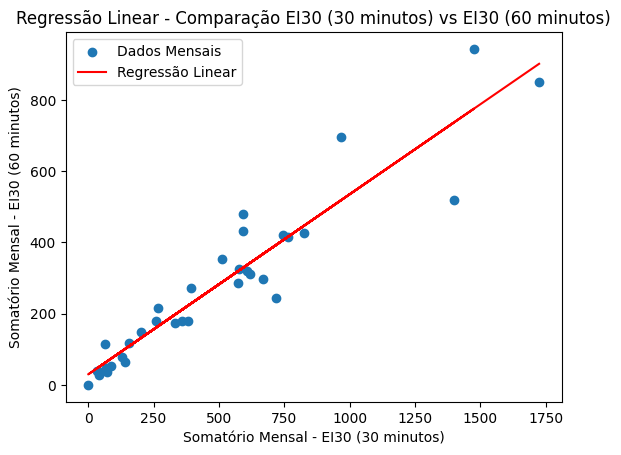

Equação Linear:
EI30_60min = 0.51 * EI30_30min + 29.61


In [ ]:
# Combinar os DataFrames
soma_mensal_combinado = pd.merge(soma_mensal_30min, soma_mensal_60min, on='MES_ANO')

# Filtrar apenas os meses/anos com valores não nulos em ambas as colunas
soma_mensal_combinado = soma_mensal_combinado.dropna()

# Separar os dados para a regressão
X = soma_mensal_combinado['EI30_30min'].values.reshape(-1, 1)
y = soma_mensal_combinado['EI30_60min'].values

# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X, y)

# Obter os coeficientes da regressão
coeficiente_angular = model.coef_[0]
intercepto_linear = model.intercept_

# Expressão da equação linear
equacao_linear = f'EI30_60min = {coeficiente_angular:.2f} * EI30_30min + {intercepto_linear:.2f}'

# Plotar os dados e a linha de regressão
plt.scatter(X, y, label='Dados Mensais')
plt.plot(X, model.predict(X), color='red', label='Regressão Linear')
plt.xlabel('Somatório Mensal - EI30 (30 minutos)')
plt.ylabel('Somatório Mensal - EI30 (60 minutos)')
plt.title('Regressão Linear - Comparação EI30 (30 minutos) vs EI30 (60 minutos)')
plt.legend()
plt.show()

# Exibir a equação linear
print('Equação Linear:')
print(equacao_linear)

# REGRESSAO ponto 2

Inseri os arquivos com EI30 de 30 minutos de cada estacao

In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import matplotlib.pyplot as plt

In [ ]:
# Carregar os dados do Excel
df_30min = pd.read_excel('ponto2_30min_chuva_com_eventos_erosivos_I_E_EcT_EI30.xlsx')
df_60min = pd.read_excel('ponto2_resultado.xlsx')

In [ ]:
df_30min.head()

,ANO,MÊS,DIA,HORA,DATA_HORA,PRECIPITACAO,Evento,erosivos,Soma_30min,I,E,E*P,EcT,EI30
0,2018,12,18,11:39:04,2018-12-18 11:39:04,2.2,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,12,18,11:44:04,2018-12-18 11:44:04,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,12,18,11:49:04,2018-12-18 11:49:04,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,12,18,11:54:04,2018-12-18 11:54:04,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,12,18,11:59:04,2018-12-18 11:59:04,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_60min

,DATA_HORA,PRECIPITACAO,Evento,I,E,E*P,EcT,EI30,Erosivos
0,2018-12-18 11:39:04,2.2,1,0.0,0.0,0.0,0.0,0.0,0
1,2018-12-18 12:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
2,2018-12-18 13:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
3,2018-12-18 14:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
4,2018-12-18 15:39:04,3.2,1,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
16942,2020-11-23 09:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
16943,2020-11-23 10:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
16944,2020-11-23 11:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0
16945,2020-11-23 12:39:04,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Extrair o mês e ano de 'DATA_HORA'
df_30min['MES_ANO'] = df_30min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_30min
soma_mensal_30min = df_30min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Extrair o mês e ano de 'DATA_HORA'
df_60min['MES_ANO'] = df_60min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_60min
soma_mensal_60min = df_60min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Renomear as colunas para evitar conflitos
soma_mensal_30min = soma_mensal_30min.rename(columns={'EI30': 'EI30_30min'})
soma_mensal_60min = soma_mensal_60min.rename(columns={'EI30': 'EI30_60min'})

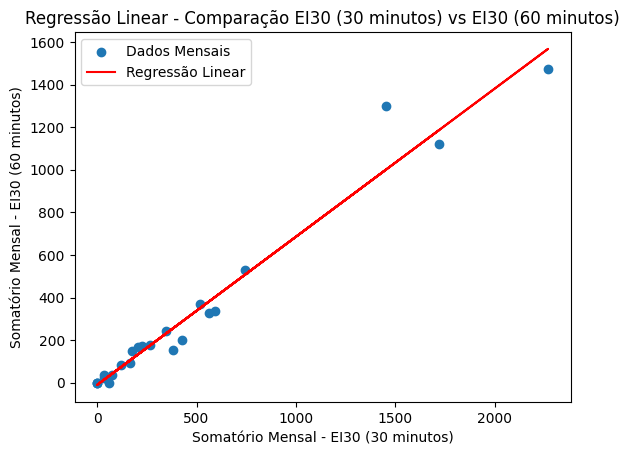

Equação Linear:
EI30_60min = 0.70 * EI30_30min + -10.04


In [ ]:
# Combinar os DataFrames
soma_mensal_combinado = pd.merge(soma_mensal_30min, soma_mensal_60min, on='MES_ANO')

# Filtrar apenas os meses/anos com valores não nulos em ambas as colunas
soma_mensal_combinado = soma_mensal_combinado.dropna()

# Separar os dados para a regressão
X = soma_mensal_combinado['EI30_30min'].values.reshape(-1, 1)
y = soma_mensal_combinado['EI30_60min'].values

# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X, y)

# Obter os coeficientes da regressão
coeficiente_angular = model.coef_[0]
intercepto_linear = model.intercept_

# Expressão da equação linear
equacao_linear = f'EI30_60min = {coeficiente_angular:.2f} * EI30_30min + {intercepto_linear:.2f}'

# Plotar os dados e a linha de regressão
plt.scatter(X, y, label='Dados Mensais')
plt.plot(X, model.predict(X), color='red', label='Regressão Linear')
plt.xlabel('Somatório Mensal - EI30 (30 minutos)')
plt.ylabel('Somatório Mensal - EI30 (60 minutos)')
plt.title('Regressão Linear - Comparação EI30 (30 minutos) vs EI30 (60 minutos)')
plt.legend()
plt.show()

# Exibir a equação linear
print('Equação Linear:')
print(equacao_linear)

# REGRESSAO ponto 4

Inseri os arquivos com EI30 de 30 minutos de cada estacao

In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import matplotlib.pyplot as plt

In [ ]:
# Carregar os dados do Excel
df_30min = pd.read_excel('ponto4_30min_chuva_com_eventos_erosivos_I_E_EcT_EI30.xlsx')
df_60min = pd.read_excel('ponto4_resultado.xlsx')

In [ ]:
df_30min.head()

,ANO,MÊS,DIA,HORA,DATA_HORA,PRECIPITACAO,Evento,erosivos,Soma_30min,I,E,E*P,EcT,EI30
0,2018,12,19,09:40:00,2018-12-19 09:40:00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,12,19,09:45:00,2018-12-19 09:45:00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,12,19,09:50:00,2018-12-19 09:50:00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,12,19,09:55:00,2018-12-19 09:55:00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,12,19,10:00:00,2018-12-19 10:00:00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_60min

,DATA_HORA,PRECIPITACAO,Evento,I,E,E*P,EcT,EI30,Erosivos
0,2018-12-19 09:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
1,2018-12-19 10:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
2,2018-12-19 11:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
3,2018-12-19 12:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
4,2018-12-19 13:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
12364,2020-05-17 13:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
12365,2020-05-17 14:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
12366,2020-05-17 15:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
12367,2020-05-17 16:40:00,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Extrair o mês e ano de 'DATA_HORA'
df_30min['MES_ANO'] = df_30min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_30min
soma_mensal_30min = df_30min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Extrair o mês e ano de 'DATA_HORA'
df_60min['MES_ANO'] = df_60min['DATA_HORA'].dt.to_period('M')

# Somatório mensal do DataFrame df_60min
soma_mensal_60min = df_60min.groupby('MES_ANO')['EI30'].sum().reset_index()

# Renomear as colunas para evitar conflitos
soma_mensal_30min = soma_mensal_30min.rename(columns={'EI30': 'EI30_30min'})
soma_mensal_60min = soma_mensal_60min.rename(columns={'EI30': 'EI30_60min'})

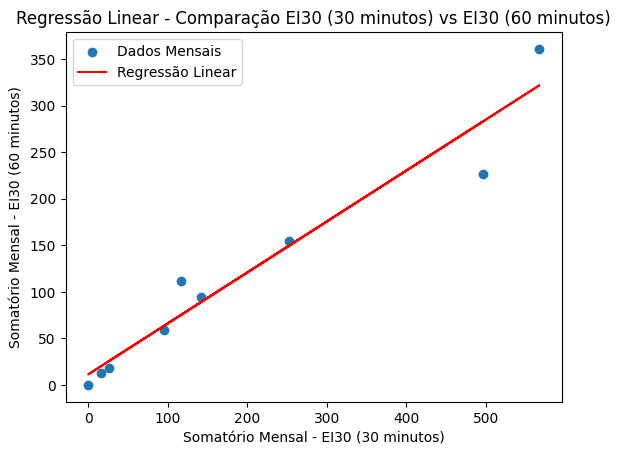

Equação Linear:
EI30_60min = 0.55 * EI30_30min + 11.33


In [ ]:
# Combinar os DataFrames
soma_mensal_combinado = pd.merge(soma_mensal_30min, soma_mensal_60min, on='MES_ANO')

# Filtrar apenas os meses/anos com valores não nulos em ambas as colunas
soma_mensal_combinado = soma_mensal_combinado.dropna()

# Separar os dados para a regressão
X = soma_mensal_combinado['EI30_30min'].values.reshape(-1, 1)
y = soma_mensal_combinado['EI30_60min'].values

# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X, y)

# Obter os coeficientes da regressão
coeficiente_angular = model.coef_[0]
intercepto_linear = model.intercept_

# Expressão da equação linear
equacao_linear = f'EI30_60min = {coeficiente_angular:.2f} * EI30_30min + {intercepto_linear:.2f}'

# Plotar os dados e a linha de regressão
plt.scatter(X, y, label='Dados Mensais')
plt.plot(X, model.predict(X), color='red', label='Regressão Linear')
plt.xlabel('Somatório Mensal - EI30 (30 minutos)')
plt.ylabel('Somatório Mensal - EI30 (60 minutos)')
plt.title('Regressão Linear - Comparação EI30 (30 minutos) vs EI30 (60 minutos)')
plt.legend()
plt.show()

# Exibir a equação linear
print('Equação Linear:')
print(equacao_linear)

# REGRESSAO todos juntos

Inseri os arquivos com EI30 de 30 minutos de cada estacao

In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import matplotlib.pyplot as plt

REGRESSÃO DADOS DE EROSIVIDADE:<br>
<br>
30 MINUTOS:<br>
Ponto 1: R em MJ mm ha-1 h-1  5761.196091001006<br>
Ponto 2: R em MJ mm ha-1 h-1  5209.736960606688<br>
Ponto 4: R em MJ mm ha-1 h-1  1140.782942454283<br>
<br>
60 MINUTOS:<br>
Ponto 1: R em MJ mm ha-1 h-1  3094.7452488266995<br>
Ponto 2: R em MJ mm ha-1 h-1  3503.2992725878366<br>
Ponto 4: R em MJ mm ha-1 h-1  692.3684173824194


In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# import numpy as np

In [ ]:
# Criar um DataFrame com os dados
data = {
    'Ponto': ['Ponto 1', 'Ponto 2', 'Ponto 4'],
    'R_30min': [5761.196091001006, 5209.736960606688, 1140.782942454283],
    'R_60min': [3094.7452488266995, 3503.2992725878366, 692.3684173824194]
}

df = pd.DataFrame(data)

In [ ]:
df

,Ponto,R_30min,R_60min
0,Ponto 1,5761.196091,3094.745249
1,Ponto 2,5209.736961,3503.299273
2,Ponto 4,1140.782942,692.368417


In [ ]:
# Aplicar a regressão linear para cada ponto
for index, row in df.iterrows():
    x = row['R_30min']
    y = row['R_60min']

    modelo = LinearRegression().fit([[x]], [y])

    coeficiente = modelo.coef_[0]
    intercepto = modelo.intercept_

    equacao = f"y = {coeficiente:.4f}x + {intercepto:.4f}"

    df.at[index, 'Coeficiente'] = coeficiente
    df.at[index, 'Intercepto'] = intercepto
    df.at[index, 'Equacao'] = equacao

# Exibir o DataFrame resultante
print(df)


     Ponto      R_30min      R_60min  Coeficiente   Intercepto  \
0  Ponto 1  5761.196091  3094.745249          0.0  3094.745249   
1  Ponto 2  5209.736961  3503.299273          0.0  3503.299273   
2  Ponto 4  1140.782942   692.368417          0.0   692.368417   

                   Equacao  
0  y = 0.0000x + 3094.7452  
1  y = 0.0000x + 3503.2993  
2   y = 0.0000x + 692.3684  


Equação da Reta de Regressão:
y = 0.5840x + 72.5664


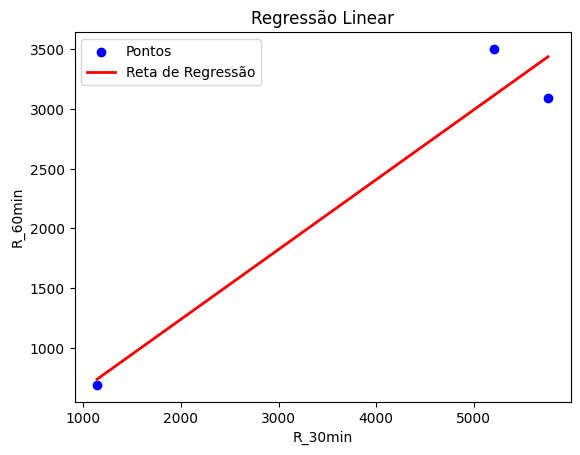

In [ ]:
# Combinar todos os dados em um único conjunto
X = df['R_30min'].values.reshape(-1, 1)
y = df['R_60min'].values

# Aplicar a regressão linear
modelo = LinearRegression().fit(X, y)

# Coeficientes da regressão
coeficiente = modelo.coef_[0]
intercepto = modelo.intercept_

# Equação da reta
equacao = f"y = {coeficiente:.4f}x + {intercepto:.4f}"

# Exibir a equação
print("Equação da Reta de Regressão:")
print(equacao)

# Plotar os dados e a reta de regressão
plt.scatter(X, y, color='blue', label='Pontos')
plt.plot(X, modelo.predict(X), color='red', linewidth=2, label='Reta de Regressão')
plt.xlabel('R_30min')
plt.ylabel('R_60min')
plt.title('Regressão Linear')
plt.legend()
plt.show()

   MES_ANO  EI30_30min_ponto1  EI30_60min_ponto1  MES_ANO  EI30_30min_ponto2  \
0  2018-02        1724.629055         849.261347  2018-12          36.196982   
1  2018-03         617.562406         311.943643  2019-01         382.075119   
2  2018-04         260.447884         179.301385  2019-02          60.295800   
3  2018-05         576.077809         324.793917  2019-03           0.000000   
4  2018-06          87.044308          52.841868  2019-04           0.000000   

   EI30_60min_ponto2  MES_ANO  EI30_30min_ponto4  EI30_60min_ponto4  
0          24.055191  2018-12          95.465657          59.106012  
1         155.124095  2019-01         251.863838         154.653226  
2           0.000000  2019-05         496.539534         226.876974  
3           0.000000  2019-06         116.555341         111.953286  
4           0.000000  2019-07           0.000000           0.000000  


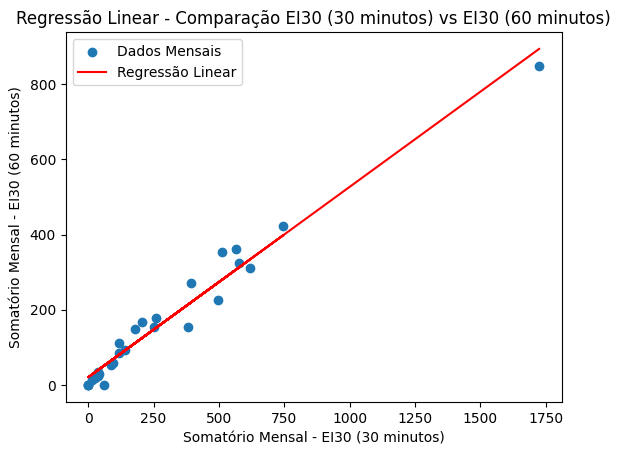

Equação Linear:
EI30_60min = 0.51 * EI30_30min + 20.47


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Lista dos pontos (1, 2, 4, etc.)
pontos = [1, 2, 4]

# Inicializar um DataFrame vazio para armazenar todos os dados
df_combinado = pd.DataFrame()

# Loop para carregar dados de todos os pontos
for ponto in pontos:
    # Carregar os dados do Excel para cada ponto
    df_30min = pd.read_excel(f'ponto{ponto}_30min_chuva_com_eventos_erosivos_I_E_EcT_EI30.xlsx')
    df_60min = pd.read_excel(f'ponto{ponto}_resultado.xlsx')

    # Extrair o mês e ano de 'DATA_HORA'
    df_30min['MES_ANO'] = df_30min['DATA_HORA'].dt.to_period('M')

    # Somatório mensal do DataFrame df_30min
    soma_mensal_30min = df_30min.groupby('MES_ANO')['EI30'].sum().reset_index()

    # Extrair o mês e ano de 'DATA_HORA'
    df_60min['MES_ANO'] = df_60min['DATA_HORA'].dt.to_period('M')

    # Somatório mensal do DataFrame df_60min
    soma_mensal_60min = df_60min.groupby('MES_ANO')['EI30'].sum().reset_index()

    # Renomear as colunas para evitar conflitos
    soma_mensal_30min = soma_mensal_30min.rename(columns={'EI30': f'EI30_30min_ponto{ponto}'})
    soma_mensal_60min = soma_mensal_60min.rename(columns={'EI30': f'EI30_60min_ponto{ponto}'})

    # Combinar os DataFrames
    soma_mensal_combinado = pd.merge(soma_mensal_30min, soma_mensal_60min, on='MES_ANO')

    # Adicionar os dados do ponto ao DataFrame combinado
    df_combinado = pd.concat([df_combinado, soma_mensal_combinado], axis=1)

# Filtrar apenas os meses/anos com valores não nulos em todas as colunas
df_combinado = df_combinado.dropna()

# Exibir os primeiros registros do DataFrame combinado
print(df_combinado.head())

# Separar os dados para a regressão
X = df_combinado.filter(regex='30min').values
y = df_combinado.filter(regex='60min').values

# Achatar os arrays para 1D
X = X.flatten()
y = y.flatten()

# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X.reshape(-1, 1), y)

# Obter os coeficientes da regressão
coeficiente_angular = model.coef_[0]
intercepto_linear = model.intercept_

# Expressão da equação linear
equacao_linear = f'EI30_60min = {coeficiente_angular:.2f} * EI30_30min + {intercepto_linear:.2f}'

# Plotar os dados e a linha de regressão
plt.scatter(X, y, label='Dados Mensais')
plt.plot(X, model.predict(X.reshape(-1, 1)), color='red', label='Regressão Linear')
plt.xlabel('Somatório Mensal - EI30 (30 minutos)')
plt.ylabel('Somatório Mensal - EI30 (60 minutos)')
plt.title('Regressão Linear - Comparação EI30 (30 minutos) vs EI30 (60 minutos)')
plt.legend()
plt.show()

# Exibir a equação linear
print('Equação Linear:')
print(equacao_linear)


   MES_ANO  EI30_30min_ponto1  EI30_60min_ponto1  MES_ANO  EI30_30min_ponto2  \
3  2018-05         576.077809         324.793917  2019-03           0.000000   
4  2018-06          87.044308          52.841868  2019-04           0.000000   
5  2018-07          40.185421          28.817937  2019-05         206.466366   
6  2018-08         510.536923         352.683045  2019-06          36.073986   
8  2018-10         746.439224         421.770190  2019-08         177.719889   

   EI30_60min_ponto2  MES_ANO  EI30_30min_ponto4  EI30_60min_ponto4  
3           0.000000  2019-06         116.555341         111.953286  
4           0.000000  2019-07           0.000000           0.000000  
5         166.662526  2019-08          16.206390          12.936585  
6          34.543861  2019-09         141.564485          94.081706  
8         147.644810  2020-05          26.109376          18.122062  


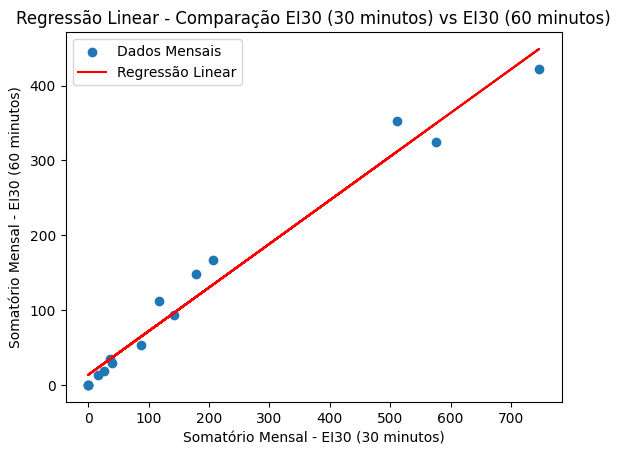

Equação Linear:
EI30_60min = 0.58 * EI30_30min + 13.49


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Lista dos pontos (1, 2, 4, etc.)
pontos = [1, 2, 4]

# Inicializar um DataFrame vazio para armazenar todos os dados
df_combinado = pd.DataFrame()

# Loop para carregar dados de todos os pontos
for ponto in pontos:
    # Carregar os dados do Excel para cada ponto
    df_30min = pd.read_excel(f'ponto{ponto}_30min_chuva_com_eventos_erosivos_I_E_EcT_EI30.xlsx')
    df_60min = pd.read_excel(f'ponto{ponto}_resultado.xlsx')

    # Extrair o mês e ano de 'DATA_HORA'
    df_30min['MES_ANO'] = df_30min['DATA_HORA'].dt.to_period('M')

    # Somatório mensal do DataFrame df_30min
    soma_mensal_30min = df_30min.groupby('MES_ANO')['EI30'].sum().reset_index()

    # Extrair o mês e ano de 'DATA_HORA'
    df_60min['MES_ANO'] = df_60min['DATA_HORA'].dt.to_period('M')

    # Somatório mensal do DataFrame df_60min
    soma_mensal_60min = df_60min.groupby('MES_ANO')['EI30'].sum().reset_index()

    # Renomear as colunas para evitar conflitos
    soma_mensal_30min = soma_mensal_30min.rename(columns={'EI30': f'EI30_30min_ponto{ponto}'})
    soma_mensal_60min = soma_mensal_60min.rename(columns={'EI30': f'EI30_60min_ponto{ponto}'})

    # Combinar os DataFrames
    soma_mensal_combinado = pd.merge(soma_mensal_30min, soma_mensal_60min, on='MES_ANO')

    # Adicionar os dados do ponto ao DataFrame combinado
    df_combinado = pd.concat([df_combinado, soma_mensal_combinado], axis=1)

# Filtrar apenas os meses/anos com valores não nulos em todas as colunas
df_combinado = df_combinado.dropna()

import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ... (seu código anterior)

# Função para remover outliers superiores usando o método IQR
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data - Q1) > 1.5 * IQR)]

# Remover outliers superiores para cada coluna do DataFrame combinado
for column in df_combinado.columns:
    if '30min' in column or '60min' in column:
        df_combinado[column] = remove_outliers(df_combinado[column])

# Filtrar novamente apenas os meses/anos com valores não nulos em todas as colunas
df_combinado = df_combinado.dropna()

# Exibir os primeiros registros do DataFrame combinado
print(df_combinado.head())

# Separar os dados para a regressão
X = df_combinado.filter(regex='30min').values
y = df_combinado.filter(regex='60min').values

# Achatar os arrays para 1D
X = X.flatten()
y = y.flatten()

# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X.reshape(-1, 1), y)

# Obter os coeficientes da regressão
coeficiente_angular = model.coef_[0]
intercepto_linear = model.intercept_

# Expressão da equação linear
equacao_linear = f'EI30_60min = {coeficiente_angular:.2f} * EI30_30min + {intercepto_linear:.2f}'

# Plotar os dados e a linha de regressão
plt.scatter(X, y, label='Dados Mensais')
plt.plot(X, model.predict(X.reshape(-1, 1)), color='red', label='Regressão Linear')
plt.xlabel('Somatório Mensal - EI30 (30 minutos)')
plt.ylabel('Somatório Mensal - EI30 (60 minutos)')
plt.title('Regressão Linear - Comparação EI30 (30 minutos) vs EI30 (60 minutos)')
plt.legend()
plt.show()

# Exibir a equação linear
print('Equação Linear:')
print(equacao_linear)


Vale a pena ler:<br>
https://www.scielo.br/j/rbcs/a/j9g8JvrGVGDyPdcn93zXvMw/?lang=en <br>
https://swr.agriculturejournals.cz/pdfs/swr/2021/02/02.pdf
